## Train mrcnn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/MaskRCNN/codeSnippet')

In [3]:
import tensorflow as tf
# !pip install tensorflow==1.5 --upgrade
print(tf.__version__)

# !pip install keras==2.2.5 --upgrade
import keras
print(keras.__version__)

!pip install -r requirements.txt
!python setup.py clean --all install

print(tf.test.gpu_device_name())

2.4.1
2.4.3
     |████████████████████████████████| 163kB 8.2MB/s 
     |████████████████████████████████| 204kB 14.8MB/s 
running clean
removing 'build/lib' (and everything under it)
removing 'build/bdist.linux-x86_64' (and everything under it)
'build/scripts-3.6' does not exist -- can't clean it
removing 'build'
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> bu

In [ ]:
os.chdir('/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet')
!python codeSnippet.py train --dataset=/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset --weights=coco

2021-02-11 10:46:59.193857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Weights:  coco
Dataset:  /content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset
Logs:  /content/drive/MyDrive/MaskRCNN/codeSnippet/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE             

## Evaluation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/MaskRCNN/codeSnippet')
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN/codeSnippet")

In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# from samples.balloon import balloon
sys.path.append(os.path.join(ROOT_DIR, "samples/codeSnippet"))
import codeSnippet


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# ovo izgleda ne sluzi nicemu
# BOTTLE_WEIGHTS_PATH = os.path.join(ROOT_DIR, 'logs/bottle20210210T1747/mask_rcnn_bottle_0013.h5')

## Configuration

In [4]:
config = codeSnippet.CustomConfig()
CODE_SNIPPET_DIR = os.path.join(ROOT_DIR, "samples/codeSnippet/dataset")
print(CODE_SNIPPET_DIR)

/content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset


In [5]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

In [6]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load validation dataset

In [8]:
# Load validation dataset
dataset = codeSnippet.CustomDataset()
dataset.load_custom(CODE_SNIPPET_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 20
Classes: ['BG', 'codeSnippet']


## Load model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Use fn_output_signature instead


In [10]:
# Set path to codeSnippet weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()
# weights_path = '/content/drive/MyDrive/MaskRCNN/codeSnippet/logs/codesnippet20210211T1047/mask_rcnn_codesnippet_0022.h5'
print(weights_path)

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

/content/drive/MyDrive/MaskRCNN/codeSnippet/logs/codesnippet20210211T1047/mask_rcnn_codesnippet_0036.h5
Loading weights  /content/drive/MyDrive/MaskRCNN/codeSnippet/logs/codesnippet20210211T1047/mask_rcnn_codesnippet_0036.h5
Re-starting from epoch 36


## Run detection

image ID: codeSnippet.Screenshot (78).png (10) /content/drive/MyDrive/MaskRCNN/codeSnippet/samples/codeSnippet/dataset/val/Screenshot (78).png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  157.00000  max:  590.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


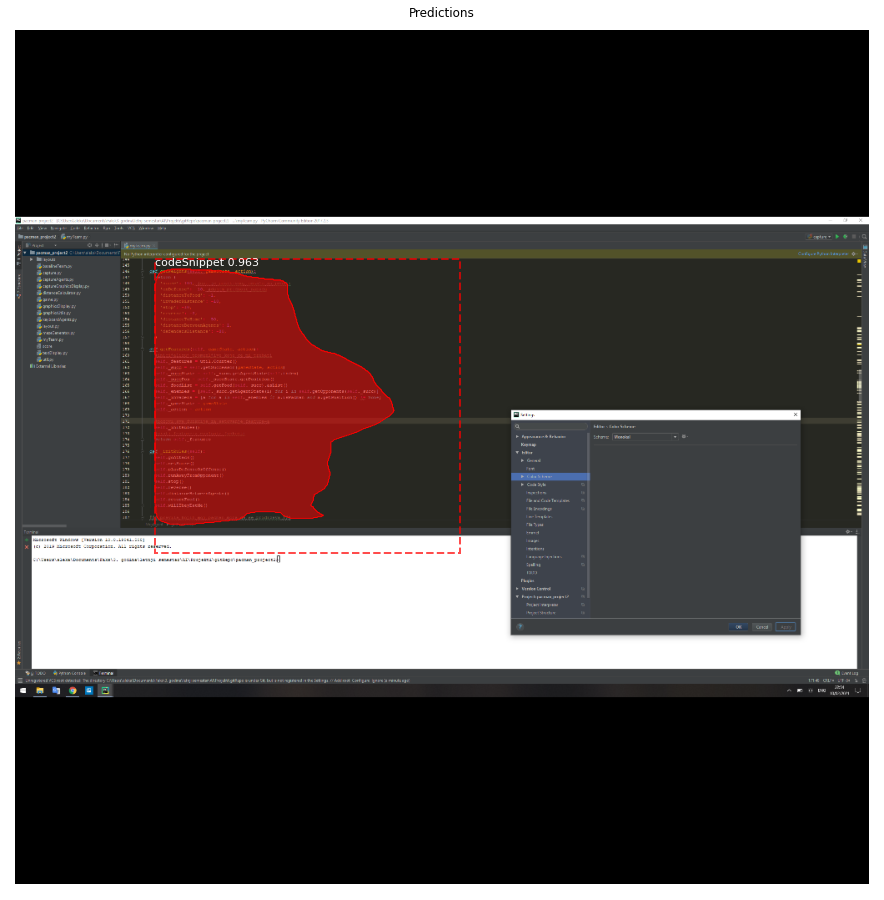

In [137]:
# image_id = random.choice(dataset.image_ids)
image_id = 10
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

# prikaz bounding boxa
# y1, x1, y2, x2 = r['rois'][0]
# p = Rectangle((x1, y1), x2-x1, y2- y1, linewidth=1, edgecolor='b', facecolor='none')
# ax.imshow(image)
# ax.add_patch(p)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:
# ovde fali poslednja cell, za sad ne treba

## Crop & save img

[[273 168 626 534]]
[122, 420, 1005, 1335]


<Figure size 6000x3600 with 0 Axes>

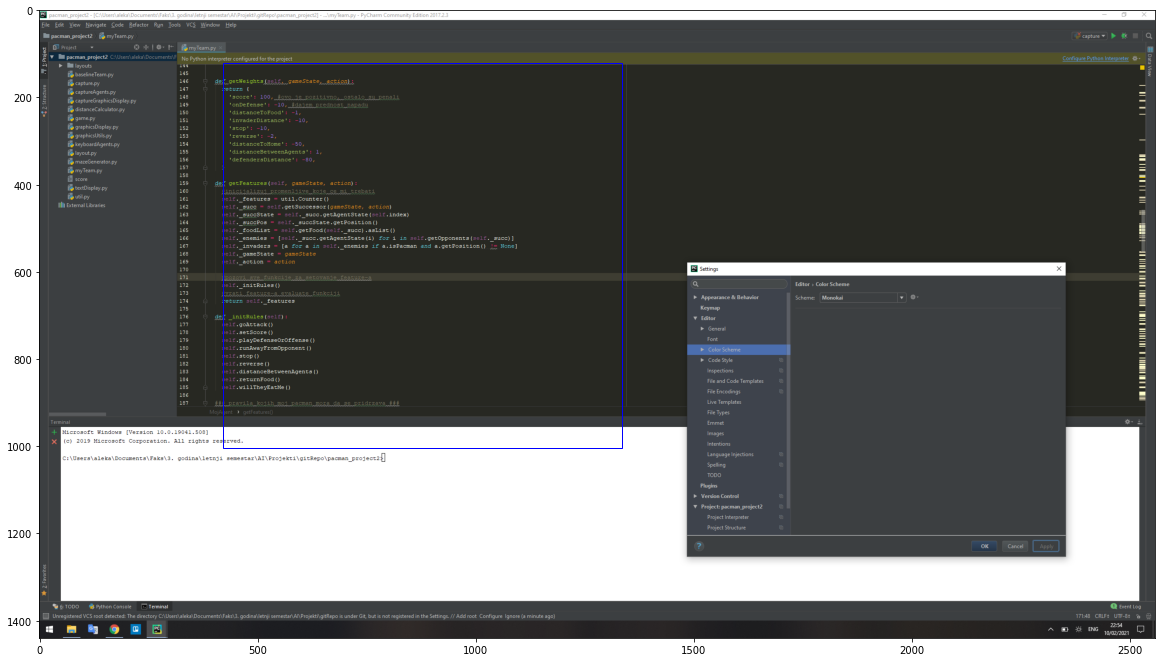

In [132]:
# iscrtavanje slika i grafika unutar samog browsera
%matplotlib inline 
# prikaz vecih slika 
matplotlib.rcParams['figure.figsize'] = 20,12
matplotlib.pyplot.figure(dpi=300)
from matplotlib.patches import Rectangle

print(r['rois'])
# skalirano za pravu sliku
ratioX = 2560 / 1024
ratioY = 416  / 1024

y1, x1, y2, x2 = r['rois'][0]
y1 = int( (y1 - 224) * ratioX)
x1 = int(x1 * ratioX)
y2 = int( (y2 - 224) * ratioX)
x2 = int(x2 * ratioX)

width = x2-x1
height = y2- y1
print([y1, x1, y2, x2])
p = Rectangle((x1, y1), width, height, linewidth=1, edgecolor='b', facecolor='none')

import cv2
image_from_disk = cv2.imread(dataset.image_reference(image_id))
image_from_disk = cv2.cvtColor(image_from_disk, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
ax.imshow(image_from_disk)
ax.add_patch(p)
# plt.savefig('proba1.jpg')

# # from cv2 import imwrite
# # cv2.imwrite('proba.jpg', crop_img)

### save image

In [138]:
image_from_disk = cv2.imread(dataset.image_reference(image_id))
image_from_disk = cv2.cvtColor(image_from_disk, cv2.COLOR_BGR2RGB)
crop_img = image_from_disk[y1:y1 +height, x1:x1 + width]

# fig, ax = plt.subplots()
# ax.imshow(crop_img)
cv2.imwrite('output/proba.jpg', crop_img)

True

In [ ]:
# OVO RADI, OVO NE DIRAJ
# opcija 2, opcija 1 je iznad
class_names = ['BG', 'codeSnippet']
image_id = 10
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)

# Run object detection
results = model.detect([image], verbose=1)

# Display results
# ax = get_ax(1)
r = results[0]
visualize.save_image(image, 'novaSlika',r['rois'], r['masks'],r['class_ids'], r['scores'], class_names)